In [3]:
library("ggplot2")
library("reshape2")
library("ggpubr")
library("naivebayes")
library("matrixStats")
library("pheatmap")
library("RColorBrewer")
library("stringr")
library("caret")
library("dplyr")

setwd("/media/scott/Zapdos/angela_prss3/scott")
source("helper.R")

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'helper.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


---
# LOADING DATA

In [2]:
load_sequencing_data()

ERROR: Error in load_sequencing_data(): could not find function "load_sequencing_data"


In [ ]:
load_gwas_results()

In [ ]:
# takes a while...
#load_array_data(gwas.df)

In [199]:
load_gtex_data(rownames(gt.matrix))
load_gtex_eqtl()

[1] "LOADING GTEX DATA"
[1] "GTEX MATRIX: gtex.matrix"
[1] "GTEX EQTLS: gtex.df"


---
# PLOT GWAS RESULTS

Warning message:
“Removed 118 rows containing missing values (geom_point).”


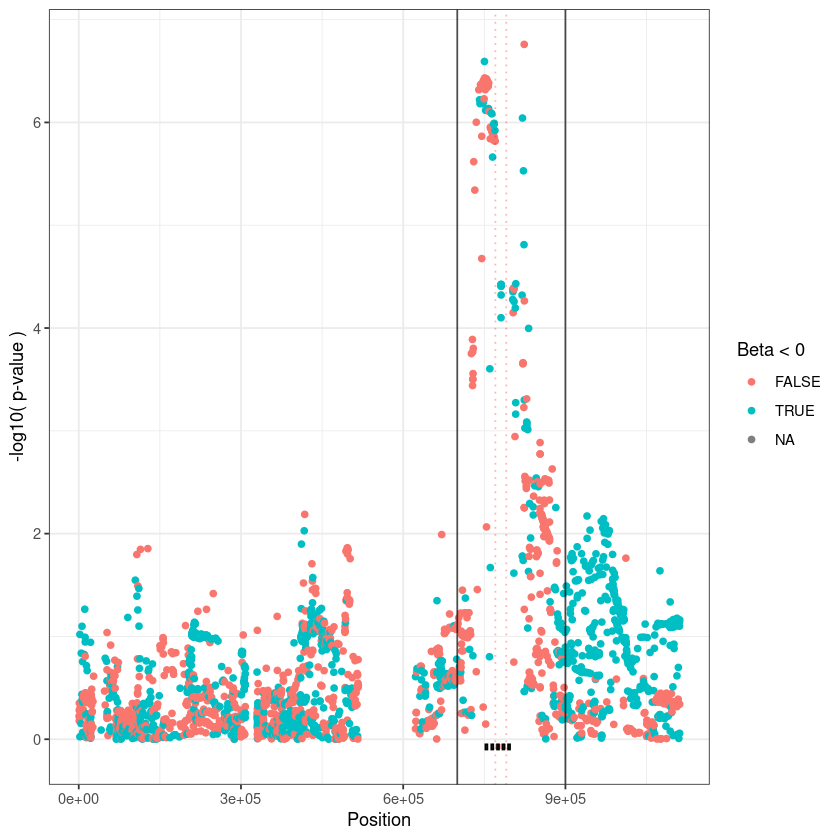

In [48]:
p <- ggplot(full.gwas.df, aes(x=pos, y=-log10(p), colour=beta>0)) +
  geom_point() + theme_bw() +
  xlab("Position") + ylab("-log10( p-value )") + labs(colour = "Beta < 0") +
  geom_vline(xintercept = REGION_START, color="black", alpha=0.7) +
  geom_vline(xintercept = REGION_END, color="black", alpha=0.7)

add_gene_rectangles(p, label=FALSE)

Warning message:
“Removed 19 rows containing missing values (geom_point).”


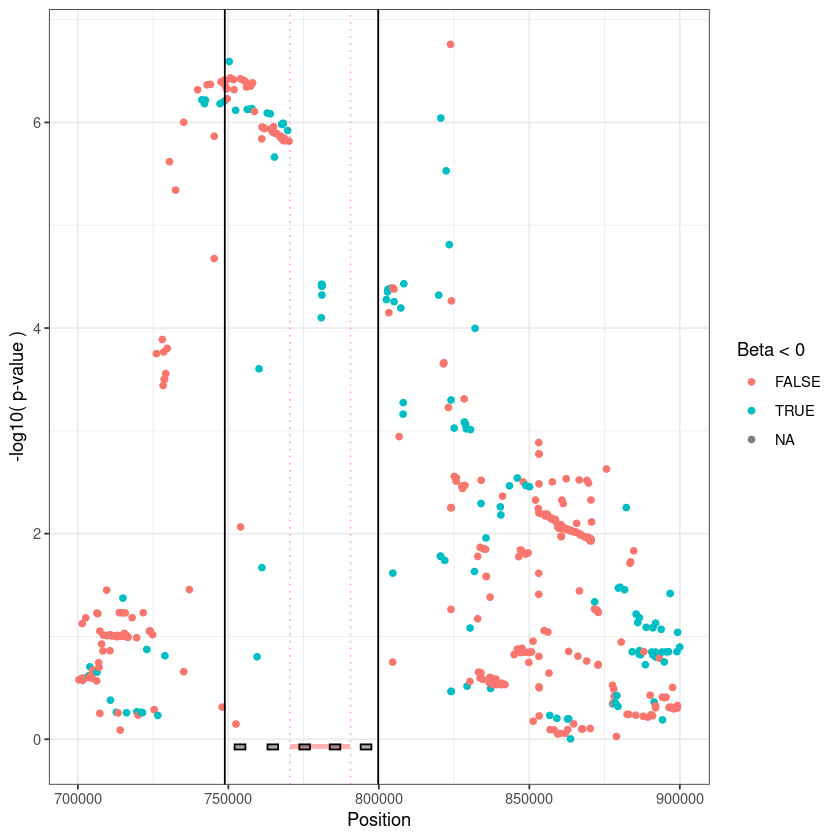

In [624]:
p <- ggplot(gwas.df, aes(x=pos, y=-log10(p), colour=beta>0)) +
  geom_point() + theme_bw() +
  xlab("Position") + ylab("-log10( p-value )") + labs(colour = "Beta < 0")
p <- p + geom_vline(xintercept = 748818, color="black")
p <- p + geom_vline(xintercept = 799779, color="black")

add_gene_rectangles(p, label=FALSE)

---
# MICROARRAY ASSOCIATION

### MODEL
```model=glm(mi ~ gt, family="binomial")```


In [50]:
microarray_regression <- function(pos, mat, dominant=FALSE){
    
    samples <- intersect(colnames(mat), array.df$sample)
    gt <- as.numeric(mat[rownames(mat) == pos, colnames(mat) %in% samples])
    if(sum(!samples == array.df[array.df$sample %in% samples,]$sample) > 0){
        print("Samples don't match properly...") }
    mi <- array.df[array.df$sample %in% samples,]$mi
    
    na <- is.na(gt) | is.na(mi)
    gt <- gt[!na] ; mi <- mi[!na]
    
    if (length(gt) == 0){ return(NA) }
    if(dominant){gt <- as.numeric(gt>=1)}
    
    model=glm(mi ~ gt, family="binomial")

    coef <- summary(model)$coefficients
    df <- data.frame(beta=coef[,1], p=coef[,4])
    df$pos <- as.numeric(pos)
    df$n <- length(gt)
    df$var <- row.names(df)
    df$gwas.p <- gwas.df[gwas.df$pos == pos,]$p
    df$gwas.af <- gwas.df[gwas.df$pos == pos,]$af
    df$gwas.beta <- gwas.df[gwas.df$pos == pos,]$beta
    rownames(df) <- NULL

    df <- df[df$var == "gt",]
    
    return(df)
}

### ASSOCIATE ALL POSITIONS

In [51]:
samples <- colnames(array.matrix)

# filter cohorts
#exclude.cohort <- array.df[array.df$cohort %in% c("FR"),]$sample
#samples <- samples[!samples %in% exclude.cohort]

# filter platforms
#keep.platform <- array.df[array.df$platform %in% c("GWAS3"),]$sample
#samples <- samples[samples %in% keep.platform]

mat=array.matrix[,colnames(array.matrix) %in% samples]

dfs <- lapply(rownames(array.matrix), FUN=microarray_regression, mat=array.matrix[,colnames(array.matrix) %in% samples])
regression.df <- do.call(rbind, na.omit(dfs))
head(regression.df[order(regression.df$p),])

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


,beta,p,pos,n,var,gwas.p,gwas.af,gwas.beta
,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>
226,0.2595422,3.323116e-05,757318,3851,gt,7.391156e-07,0.4093944,0.2428309
232,0.1968868,3.879215e-05,803000,6529,gt,4.202970e-05,0.4739261,0.1984939
233,0.1928583,5.474508e-05,803852,6525,gt,4.103923e-05,0.4773744,0.1981874
235,0.1837783,8.377068e-05,807295,6804,gt,6.386535e-05,0.4772526,0.1920568
222,-0.2421827,1.056756e-04,750699,3839,gt,3.688519e-07,0.5682046,-0.2488027
217,-0.1719426,2.884699e-04,729701,6529,gt,1.577271e-04,0.5484276,-0.1823463


### PLOT ASSOCIATION

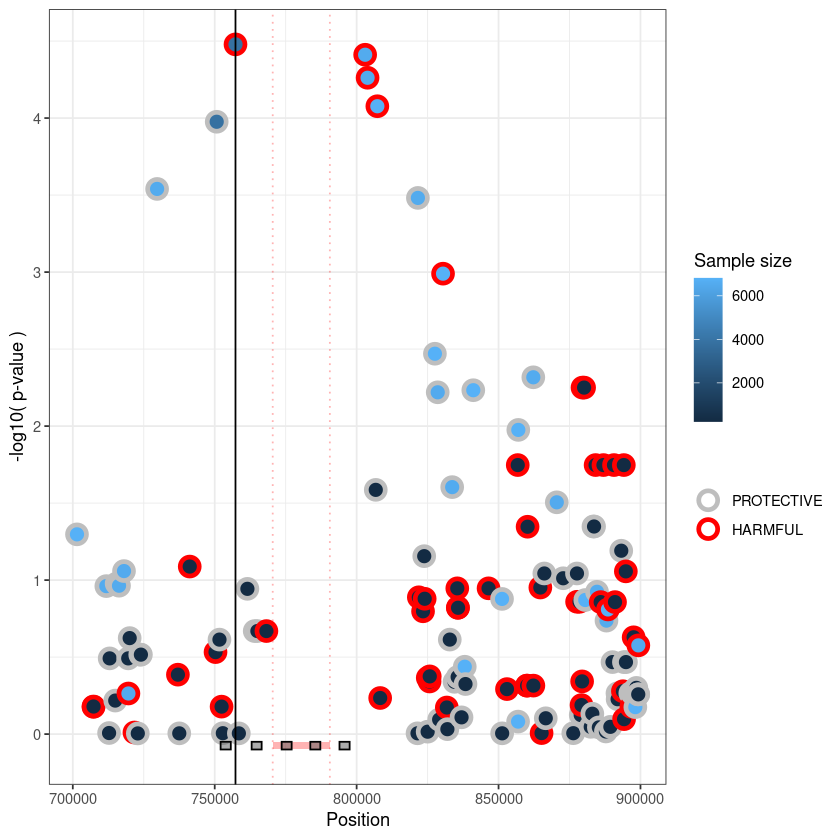

In [606]:
p <- ggplot(regression.df, aes(x=pos, y=-log10(p), colour=beta>0, fill=n)) +
  geom_point(shape=21, size=4, stroke=2) + theme_bw() +
      scale_colour_manual(values=c("grey", "red"),
                          labels = c("PROTECTIVE", "HARMFUL", "")) +
  xlab("Position") + ylab("-log10( p-value )") + labs(color="", fill = "Sample size")
p <- p + geom_vline(xintercept = 757318, color="black")

add_gene_rectangles(p, label=FALSE)

---
# ARRAY vs SEQUENCING DATA 

In [53]:
load_sample_overlap(array.df$sample, colnames(gt.matrix))
head(overlap.df)

[1] "LOADING OVERLAP DATA"
[1] "55 SAMPLES OVERLAP"
[1] "OVERLAPING INFO: overlap.df"


,array.id,seq.id,platform,mi
,<fct>,<fct>,<fct>,<int>
1,GC3892_03,AFO3892_03,GWAS1,0
2,DEN0218,BSP21040_03A,GWAS1,1
3,GC0090_03,BSP21041_03A,GWAS1,0
4,TOR0163-03,BSP21045_03A,GWAS2,0
5,GC0025_03,BSP21082_03,GWAS1,0
6,GC0172_03,BSP21083_03A,GWAS1,0


### CORRELATION BETWEEN OVERLAPPING SAMPLES

In [54]:
correlate_samples <- function(seq.id){
    array.id <- overlap.df[overlap.df$seq.id == seq.id,]$array.id    
    positions <- as.numeric(intersect(rownames(gt.matrix), rownames(array.matrix)))
    
    x1 <- gt.matrix[rownames(gt.matrix) %in% positions, ]
    x1 <- x1[order(as.numeric(rownames(x1))),]
    x1 <- x1[, colnames(x1) == seq.id]
    
    x2 <- array.matrix[rownames(array.matrix) %in% positions, ]
    x2 <- x2[order(as.numeric(rownames(x2))),]
    x2 <- x2[, colnames(x2) == array.id]
    
    omit <- is.na(x1) | is.na(x2)

    r <- cor(x1[!omit], x2[!omit])
    
    return (r)
}

correlations <- sapply(overlap.df$seq.id, FUN=correlate_samples)
correlations
overlap.df$corr <- correlations

overlap.df <- overlap.df[overlap.df$corr > 0.9,]
table(array.df[array.df$sample %in% overlap.df$array.id,]$platform)

[1] 1.0000000 0.3868193 1.0000000 1.0000000 0.3530023 1.0000000 1.0000000
 [8] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
[15] 1.0000000 1.0000000 1.0000000 0.9354143 1.0000000 1.0000000 1.0000000
[22] 1.0000000 1.0000000 1.0000000 0.9491327 1.0000000 1.0000000 1.0000000
[29] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
[36] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 0.4763609 1.0000000
[43] 0.6237685 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
[50] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000


 370K  660K  660W GWAS1 GWAS3 Omni5 
    0     0    18    32     0     1 

### DIRECTION OF EFFECT IN SEQUENCING DATA

In [55]:
mi_pct <- function(gt, target){
    mat <- gt.matrix[,gt.matrix[rownames(gt.matrix)==target,]==gt]
    mi.status <- sapply(colnames(mat), 
                        FUN=function(x) seq.df[seq.df$sample == x,]$mi)
    return(round(mean(mi.status),3))
}

n <- function(gt, target){
    mat <- gt.matrix[,gt.matrix[rownames(gt.matrix)==target,]==gt]
    return(ncol(mat))
}

#af <- function(target){
#    return(sum(gt.matrix[rownames(gt.matrix)==target,])/(nrow(gt.matrix)*2))
#}

plot_mi_percentage <- function(positions, to.plot=TRUE){
    mi.pc <- lapply(positions, FUN=function(x) sapply(c(0,1,2), FUN=mi_pct, target=x))
    n.count <- lapply(positions, FUN=function(x) sapply(c(0,1,2), FUN=n, target=x))

    m1 <- as.data.frame(do.call(rbind, mi.pc)) 
    colnames(m1) <- c("0", "1", "2") ; m1$pos <- positions
    m1 <- melt(m1, id.vars="pos") ; colnames(m1) <- c("pos", "gt", "mi.pc")

    m2 <- as.data.frame(do.call(rbind, n.count)) 
    colnames(m2) <- c("0", "1", "2") ; m2$pos <- positions
    m2 <- melt(m2, id.vars="pos") ; colnames(m2) <- c("pos", "gt", "n")

    mi.df <- merge(m1,m2, by=c("pos","gt"))

    if (to.plot){
        p1 <- ggplot(mi.df, aes(x=gt, y=mi.pc, color=gt)) +
          geom_boxplot() + theme_bw() +
          xlab("") + ylab("MI Proportion") + labs(color = "Genotype")

        p2 <- ggplot(mi.df, aes(x=gt, y=n, color=gt)) +
          geom_boxplot() + theme_bw() +
          xlab("") + ylab("Sample Size") + labs(color = "Genotype")   

        print(ggarrange(plotlist=list(p1,p2), labels = c("MI","n"), common.legend=TRUE))
    }         
    return(mi.df)
}

[1] "SNPs with p<1e-5 and beta<0 in GWAS (significant and protective)"


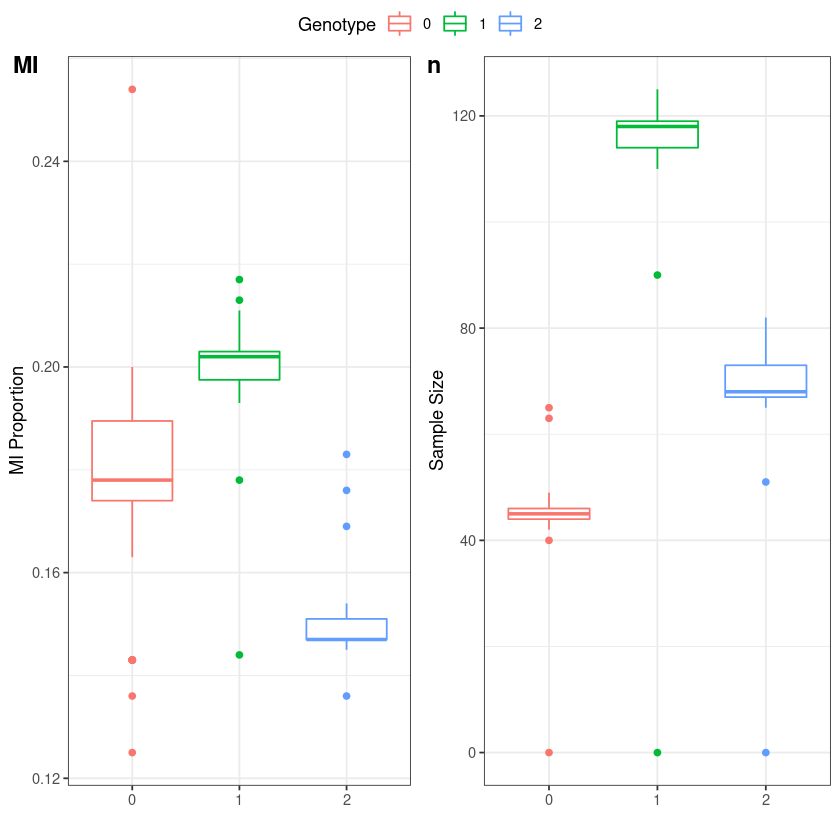

In [56]:
sig.df <- na.omit(gwas.df[gwas.df$p < 1e-5 & gwas.df$beta < 0 ,])
print("SNPs with p<1e-5 and beta<0 in GWAS (significant and protective)")
options(warn=-1)
tab <- plot_mi_percentage(sig.df$pos)
options(warn=0)

[1] "SNPs with p<1e-5 and beta>0 in GWAS (significant and harmful)"


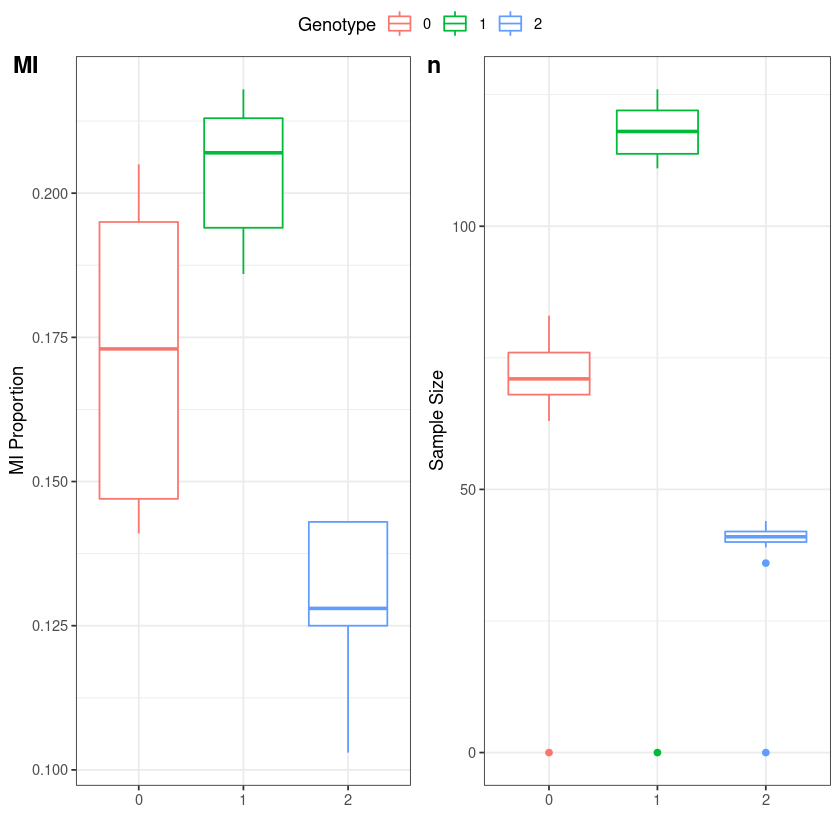

In [57]:
sig.df <- na.omit(gwas.df[gwas.df$p < 1e-5 & gwas.df$beta > 0 ,])
print("SNPs with p<1e-5 and beta>0 in GWAS (significant and harmful)")
options(warn=-1)
tab <- plot_mi_percentage(sig.df$pos)
options(warn=0)

### STATISTICAL POWER OF SEQUENCING DATA 

In [58]:
print("Top harmful (non-imputed) SNP in GWAS")
pos="757318"
gwas.df[gwas.df$pos == pos,]

print("SNP is protective in sequencing data")
plot_mi_percentage(pos, to.plot=FALSE)

[1] "Top harmful (non-imputed) SNP in GWAS"


,snp,chr,pos,chr.19,pos.19,a1,a2,beta,se,p,af,n,reversed
,<fct>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
950,rs1985888,chr7_KI270803v1_alt,757318,chr7,142462572,G,A,0.2428309,0.04904889,7.391156e-07,0.4093944,6770,0


[1] "SNP is protective in sequencing data"


pos,gt,mi.pc,n
<chr>,<fct>,<dbl>,<int>
757318,0,0.203,74
757318,1,0.186,118
757318,2,0.125,40


### SIMULATE SEQUENCING RESULTS

No id variables; using all as measure variables



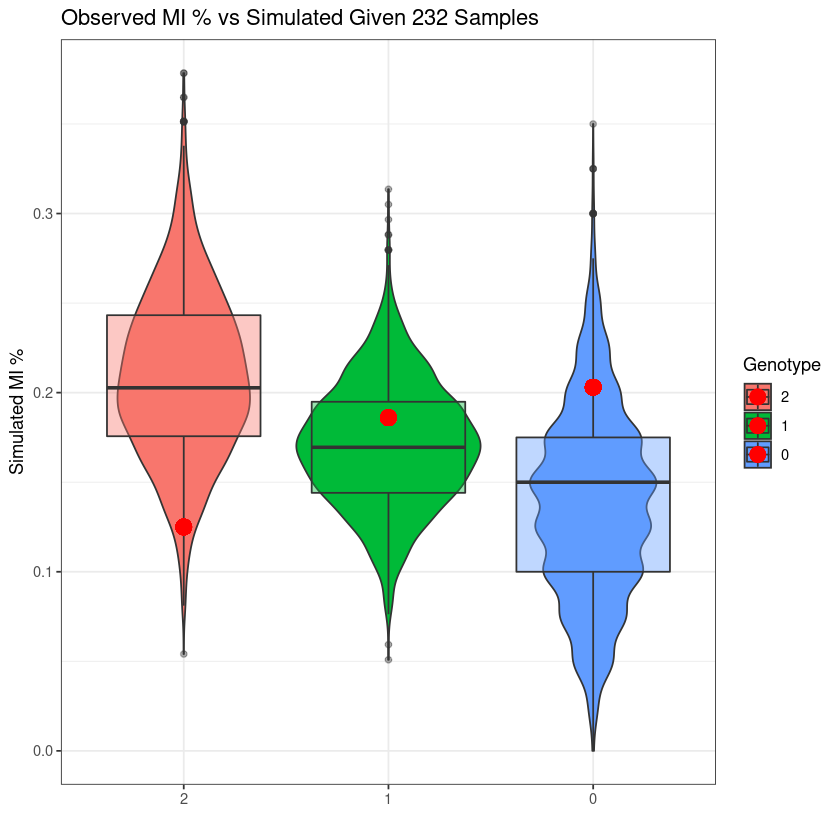

In [627]:
# MI % in GWAS data for each gt, treat as truth
p2=0.2090762 ; p1=0.17100372 ; p0=0.1361954 

# expected samples under Hardy-Weinberg...
maf=0.40939439 ; n=232
n2 = n * (maf*maf)
n1 = n * 2*((1-maf)*maf)
n0 = n * ((1-maf)*(1-maf))

# ...or use actual counts in sequence data
n2 = 74 ; n1 = 118 ; n0 = 40

# observed mi % in sequencing data
o2 = 0.125 ; o1 = 0.186 ; o0 = 0.203

simulate <- function(x){
    x1=mean(rbinom(n=round(n2), size=1, prob=p2))
    x2=mean(rbinom(n=round(n1), size=1, prob=p1))
    x3=mean(rbinom(n=round(n0), size=1, prob=p0))
    return(c(x1, x2, x3))
}

simulate.df <- as.data.frame(do.call(rbind, lapply(1:2000, FUN=simulate)))
colnames(simulate.df) <- c("2", "1", "0")
simulate.df <- melt(simulate.df)
colnames(simulate.df) <- c("gt", "mi.pc")

p <- ggplot(simulate.df, aes(x=gt, y=mi.pc, fill=gt)) +
  geom_violin() + geom_boxplot(alpha=0.4) + theme_bw() +
  ggtitle(paste("Observed MI % vs Simulated Given", n,"Samples")) +
  geom_point(x="0", y=o0, color="red", size=4) +
  geom_point(x="1", y=o1, color="red", size=4) +
  geom_point(x="2", y=o2, color="red", size=4) +
  xlab("") + ylab("Simulated MI %") + labs(fill = "Genotype")
p

---
# HAPLOTYPE ANALYSIS

In [548]:
# takes some time...
#imputed.hap.mat <- impute_hap_matrix(hap.matrix, k=5)

In [ ]:
start.pos <- min(na.omit(gwas.df[-log10(gwas.df$p) > 6, ]$pos))
end.pos <- max(na.omit(gwas.df[-log10(gwas.df$p) > 6, ]$pos))
print(paste(start.pos, end.pos))

mat <- imputed.hap.mat[as.numeric(rownames(imputed.hap.mat)) > start.pos &
                      as.numeric(rownames(imputed.hap.mat)) < end.pos,]

mat[mat < 0] <- NA
clusters <- hierarchical_cluster_haplotypes(mat, k=3, plot.clusters=TRUE,
                                dist.meth="manhattan", clust.meth="ward.D2")

rep <- c("QUL28163_03A.1", "BSP21041_03A.2", "OSK7706_03A.1")
labels <- "ACD"

clusters <- label_clusters(clusters, rep, labels)


In [ ]:
start.pos <- min(na.omit(gwas.df[-log10(gwas.df$p) > 6, ]$pos))
end.pos <- max(na.omit(gwas.df[-log10(gwas.df$p) > 6,]$pos))

mat <- imputed.hap.mat[as.numeric(rownames(imputed.hap.mat)) > start.pos &
                      as.numeric(rownames(imputed.hap.mat)) < end.pos,]
#mat[mat < 0] <- 0.5

clusters <- kmeans_cluster_haplotypes2(mat, k=4, seed=438, method="manhattan", plot.clusters=TRUE)

rep <- c("QUL28163_03A.1", "OSK7719_03A.1", "BSP21041_03A.2", "OSK7706_03A.1")
labels <- "ABCD"

clusters <- label_clusters(clusters, rep, labels)
collapse_clusters(clusters$hap.df, imputed.hap.mat)


  A   B   C   D 
255   3   3 203 


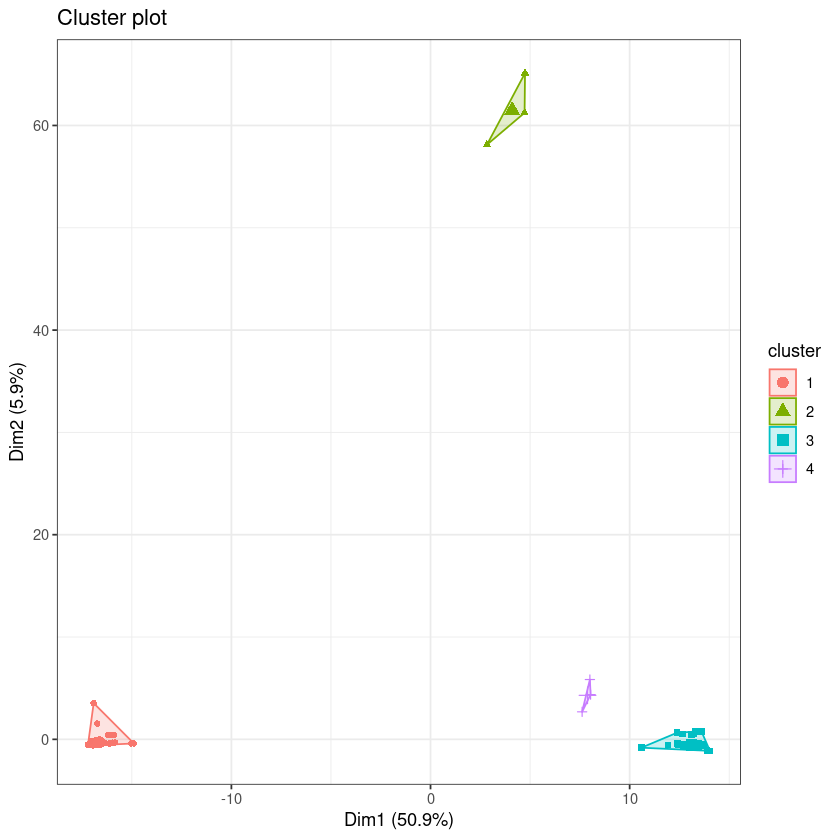

,700361,700890,700891,700892,700903,700921,701105,701147,701149,701151,⋯,898711,898716,899028,899147,899149,899158,899162,899212,899247,899955
A,0.5333333,0.03921569,0.03529412,0.04313725,0.007843137,0.000000000,0.5333333,0.007843137,0.007843137,0.007843137,⋯,0.003921569,0.003921569,0.01568627,0.01176471,0.01176471,0.9294118,0.01176471,0.9372549,0.003921569,0.003921569
B,0.3333333,0.00000000,0.00000000,0.00000000,0.000000000,0.000000000,0.3333333,0.000000000,0.000000000,0.000000000,⋯,0.000000000,0.000000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.3333333,0.666666667,0.000000000
D,0.2167488,0.01970443,0.01970443,0.01970443,0.000000000,0.009852217,0.2167488,0.000000000,0.000000000,0.000000000,⋯,0.019704433,0.019704433,0.01477833,0.00000000,0.00000000,0.9162562,0.00000000,0.9162562,0.054187192,0.054187192
C,1.0000000,0.00000000,0.00000000,0.00000000,0.000000000,0.000000000,1.0000000,0.000000000,0.000000000,0.000000000,⋯,0.000000000,0.000000000,0.00000000,0.00000000,0.00000000,0.3333333,0.00000000,0.3333333,0.333333333,0.000000000


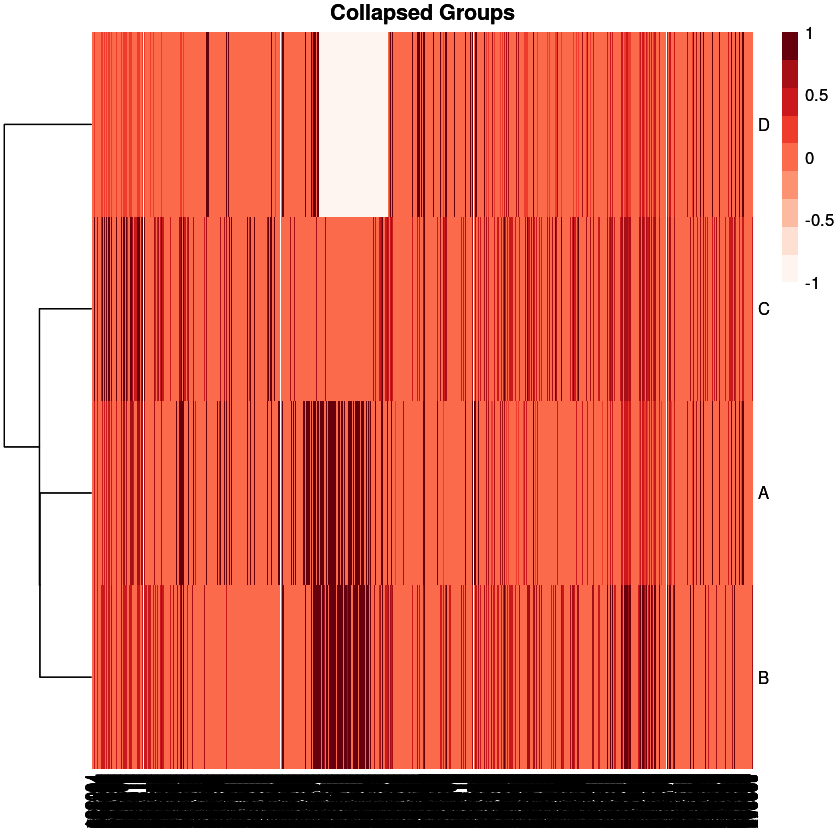

In [605]:
START_CLUSTER <- 748818
END_CLUSTER   <- 799779

mat <- imputed.hap.mat[as.numeric(rownames(imputed.hap.mat)) > START_CLUSTER &
                      as.numeric(rownames(imputed.hap.mat)) < END_CLUSTER,]

clusters <- kmeans_cluster_haplotypes(mat, k=4, plot.clusters=TRUE)

rep <- c("QUL28163_03A.1", "OSK7719_03A.1", "BSP21041_03A.2", "OSK7706_03A.1")
labels <- "ABCD"

clusters <- label_clusters(clusters, rep, labels)
collapse_clusters(clusters$hap.df, imputed.hap.mat)

In [ ]:
source("helper.R")

#START_CLUSTER <- 748818
#END_CLUSTER   <- 799779
#start.pos <- min(na.omit(gwas.df[-log10(gwas.df$p) > 6, ]$pos))
#end.pos <- max(na.omit(gwas.df[-log10(gwas.df$p) > 6, ]$pos))
#mat <- imputed.hap.mat[as.numeric(rownames(imputed.hap.mat)) > start.pos &
#                      as.numeric(rownames(imputed.hap.mat)) < end.pos,]

mat <- imputed.hap.mat[as.numeric(rownames(imputed.hap.mat)) > START_CLUSTER &
                      as.numeric(rownames(imputed.hap.mat)) < END_CLUSTER,]
mat[mat < 0] <- 0.5

set.seed(428)
clusters <- kmeans_cluster_haplotypes(mat, k=4, plot.clusters=TRUE)

rep <- c("QUL28163_03A.1", "OSK7719_03A.1", "BSP21041_03A.2", "OSK7706_03A.1")
labels <- "ABCD"

clusters <- label_clusters(clusters, rep, labels)
collapse_clusters(clusters$hap.df, imputed.hap.mat)

In [567]:
group_average <- function(group, mat, cluster.df){
    samp <- cluster.df[cluster.df$cluster == as.character(group),]$sample
    samp <- as.character(samp)
    rows <- mat[, colnames(mat) %in% samp]
    if (length(samp) < 1 ){ return (NA) } 
    if (length(samp) == 1 ){ return(rows) }
    return(rowMeans(rows, na.rm = TRUE))
}

collapse_clusters <- function(cluster.df, geno.matrix, title="Collapsed Groups", to.plot=TRUE, free.cols=FALSE){
    groups <- unique(cluster.df$cluster)
    collapsed.matrix <- do.call(rbind, na.omit(lapply(groups, FUN=group_average,
                        mat=geno.matrix, cluster.df=cluster.df)))
    collapsed.matrix <- as.matrix(collapsed.matrix)
    rownames(collapsed.matrix) = groups

    if(to.plot){
        print(pheatmap(collapsed.matrix, color=RColorBrewer::brewer.pal(9, "Reds"),
         scale = "none", cluster_cols=free.cols, main=title))
    }
    return(collapsed.matrix)
}

---
# NAIVE BAYES CLASSIFICATION

### BOOTSTRAPPING DIPLOTYPES

In [618]:
split_id <- function(x){ return(strsplit(x, split=c("\\."))[[1]][1]) }
split_num <- function(x){ return(strsplit(x, split=c("\\."))[[1]][2]) }

get_hap_group <- function(hap, clust){ return(clust$hap.df[clust$hap.df$sample == hap,]$cluster) }

bootstrap_diplotypes <- function(bootstrap.size, clust){
    h1 <- imputed.hap.mat[,sample(ncol(imputed.hap.mat), size=bootstrap.size, replace=TRUE)]
    h2 <- imputed.hap.mat[,sample(ncol(imputed.hap.mat), size=bootstrap.size, replace=TRUE)]
    bootstrap.mat <- h1 + h2

    hap.labels <- cbind(sapply(colnames(h1), get_hap_group, clust=clust),
                        sapply(colnames(h2), get_hap_group, clust=clust))
    hap.labels <- sapply(1:nrow(hap.labels), 
                         FUN=function(i) paste(hap.labels[i,1], hap.labels[i,2], sep=""))
    hap.labels <- sapply(hap.labels, FUN=function(s) paste(sort(unlist(strsplit(s, ""))), collapse = ""))
    hap.labels <- as.character(hap.labels)
    
    return(list(matrix=bootstrap.mat, labels=hap.labels))
}

predict_bootstrap <- function(genotype.matrix, clust, bootstrap.size, bootstrap.n, laplace=0.5){                    
    pred.mat <- t(genotype.matrix)
    #remove if missing >5% of data
    missing <- apply(pred.mat,2, FUN=function(x) sum(is.na(x)))
    pred.mat <- pred.mat[, missing/ncol(pred.mat) <= 0.05]
    samples <- rownames(pred.mat)
    pred.mat <- as.matrix(kNN(pred.mat, k=5, imp_var=FALSE))
    rownames(pred.mat) <- samples

    bootstrap <- function(i){
        bs <- bootstrap_diplotypes(bootstrap.size, clust)
        train.mat <- t(bs$matrix)
        class.lab <- bs$labels
        train.mat <- train.mat[,colnames(train.mat) %in% colnames(pred.mat)]
        pred.mat <- pred.mat[,colnames(pred.mat) %in% colnames(train.mat)]

        pnb <- poisson_naive_bayes(x=train.mat, y=class.lab, laplace=laplace)
        #summary(pnb)
        
        labels <<- class.lab
        pr <<- pred.mat
        tr <<- train.mat

        
        #print(pred.mat)
        hap.prediction <- predict(pnb, pred.mat, type="class")
        hap.posterior <- rowMaxs(predict(pnb, pred.mat, type = "prob"))
        df <- data.frame(sample=samples, cluster=hap.prediction, posterior=hap.posterior)

        return(df)
    }

    boot.df <- do.call(rbind, lapply(1:bootstrap.n, bootstrap))

    vote <- function(samp){
        tt <- table(boot.df[boot.df$sample == samp,]$cluster)
        return(names(tt[which.max(tt)]))   
    }
                     
    haplotype.vote <- sapply(samples, FUN=vote)
    mean.posterior <- sapply(samples, 
                    FUN=function(x) mean(boot.df[boot.df$sample == x,]$posterior))

    df <- data.frame(sample=samples, cluster=haplotype.vote, posterior=mean.posterior)
    df$sample <- as.character(df$sample)
    df$cluster <- as.character(df$cluster)
    
    return (df)
}

In [619]:
b.size <- ncol(hap.matrix)
b.n <- 21

get_platform_matrix <- function(platform){
    samples <- array.df[array.df$platform %in% platform,]$sample
    mat <- as.matrix(array.matrix[,colnames(array.matrix) %in% samples])
    return(mat)
}

platforms <- list(c("Omni5"), c("660W", "660K", "GWAS3"), c("GWAS1"), c("370K"))
mats <- lapply(platforms, get_platform_matrix)

predict.df <- do.call(rbind, lapply(mats, FUN=predict_bootstrap, clust=clusters,
                                    bootstrap.size=b.size, bootstrap.n=b.n))

predict.df$platform <- merge(predict.df, array.df, by="sample", all.x=TRUE)$platform

table(predict.df$cluster)



  AA   AB   AC   AD   BD   CD   DD 
1783   22   16 3836   25   27 1104 

### POSTERIOR PROBABILITIES

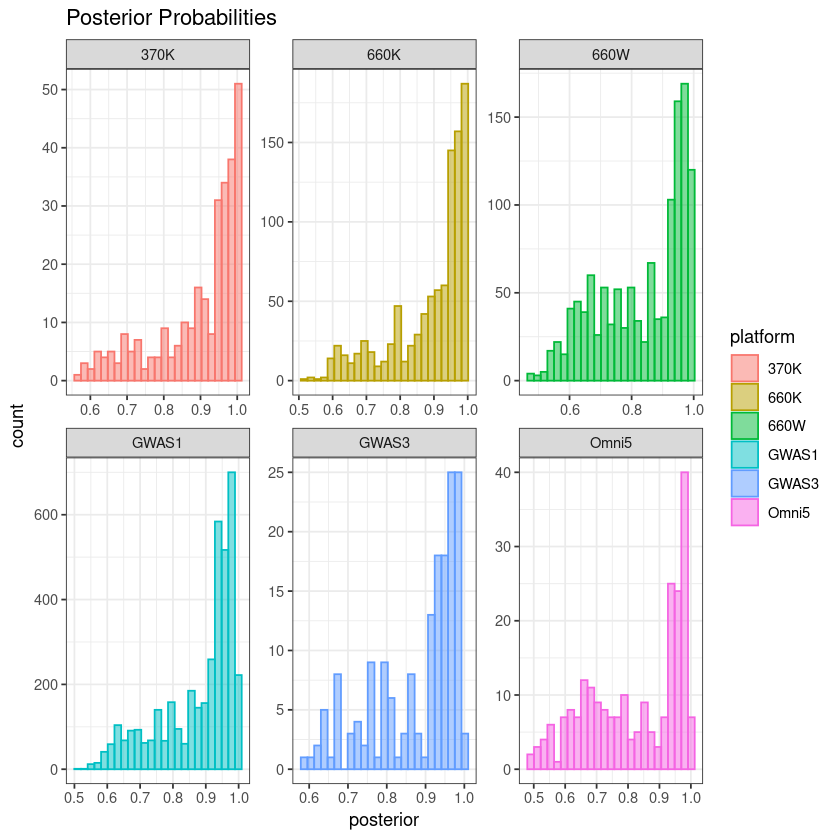

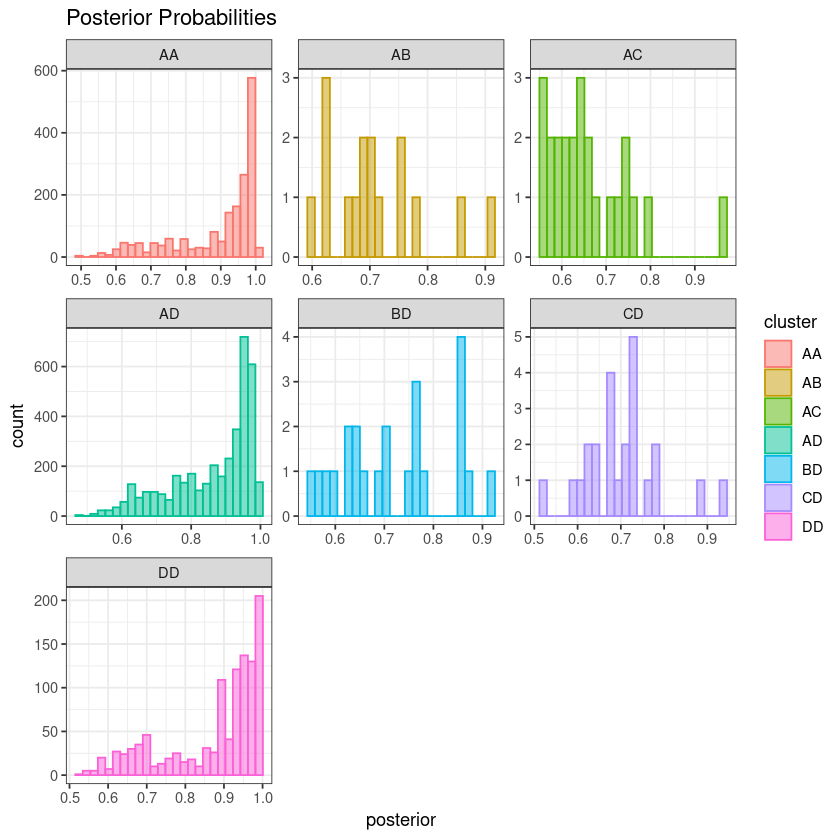

In [570]:
ggplot(predict.df, aes(x=posterior, fill=platform, color=platform)) +
  geom_histogram(alpha=0.5, position="identity", bins=25) + theme_bw() +
  facet_wrap(~platform, scales="free") + ggtitle("Posterior Probabilities")

ggplot(predict.df, aes(x=posterior, fill=cluster, color=cluster)) +
  geom_histogram(alpha=0.5, position="identity", bins=25) + theme_bw() +
  facet_wrap(~cluster, scales="free") + ggtitle("Posterior Probabilities")

### CONFUSION MATRIX

In [600]:
make_confusion_matrix <- function(predicted, expected){
    res <- data.frame(pred=predicted, exp=expected)
    levels=unique(c(unique(as.character(res$pred)), unique(as.character(res$exp))))
    res$pred <- factor(res$pred, levels)
    res$exp <- factor(res$exp, levels)

    confusionMatrix(res$pred, res$exp)
}

make_confusion_matrix(
    sapply(overlap.df$seq.id, function(x) as.character(cl[cl$sample == as.character(x), ]$cluster)),
    sapply(overlap.df$array.id, function(x) as.character(predict.df[predict.df$sample == as.character(x), ]$cluster)))

Confusion Matrix and Statistics

          Reference
Prediction AD CD DD AA
        AD 21  0  1  0
        CD  1  0  0  0
        DD  1  0 11  0
        AA  3  0  0 13

Overall Statistics
                                          
               Accuracy : 0.8824          
                 95% CI : (0.7613, 0.9556)
    No Information Rate : 0.5098          
    P-Value [Acc > NIR] : 1.96e-08        
                                          
                  Kappa : 0.8175          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: AD Class: CD Class: DD Class: AA
Sensitivity             0.8077        NA    0.9167    1.0000
Specificity             0.9600   0.98039    0.9744    0.9211
Pos Pred Value          0.9545        NA    0.9167    0.8125
Neg Pred Value          0.8276        NA    0.9744    1.0000
Prevalence              0.5098   0.00000    0.2353    0.2549
Detection Rate          0.4118   0.0

In [572]:
cluster_regression <- function(group, samples, note=NA, equals=NA){
    
    merge.df <- merge(predict.df, array.df, by="sample", all.x=TRUE)
    merge.df <- merge.df[merge.df$sample %in% samples,]
    merge.df$cluster.count <- str_count(merge.df$cluster, pattern=group)

    if(!is.na(equals)){ merge.df$cluster.count = as.numeric(merge.df$cluster.count==equals) }

    model=glm(mi ~ cluster.count, family="binomial", data=merge.df)
        
    coef <- summary(model)$coefficients
    df <- data.frame(beta=coef[,1], p=coef[,4])
    df$var <- row.names(df)
    df$group <- group
    row.names(df) <- NULL
    n <- 2*nrow(merge.df)
    df$mi.0 <- nrow(merge.df[merge.df$cluster.count==0 & merge.df$mi == 1,])/sum(merge.df$cluster.count==0)
    df$mi.1 <- nrow(merge.df[merge.df$cluster.count==1 & merge.df$mi == 1,])/sum(merge.df$cluster.count==1)
    df$mi.2 <- nrow(merge.df[merge.df$cluster.count==2 & merge.df$mi == 1,])/sum(merge.df$cluster.count==2)
    df$n <- n
    df$count <- sum(merge.df$cluster.count)
    if (!is.na(note)) {df$note <- note}
    df <- df[df$var == "cluster.count",]
    return(df)
}

In [573]:
groups <- unique(clusters$hap.df$cluster)
do.call("rbind", lapply(groups, FUN=function(x) cluster_regression(samples=predict.df$sample, x)))
                 
do.call("rbind", lapply(as.character(unique(array.df$cohort)),
    FUN=function(cohort) do.call("rbind", lapply(groups, cluster_regression, 
                samples=array.df[array.df$cohort == cohort,]$sample, note=cohort))))
         
do.call("rbind", lapply(as.character(unique(array.df$platform)),
    FUN=function(platform) do.call("rbind", lapply(groups, cluster_regression, 
                samples=array.df[array.df$platform == platform,]$sample, note=platform))))

,beta,p,var,group,mi.0,mi.1,mi.2,n,count
,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2,-0.1961499,8.829961e-05,cluster.count,A,0.1936041,0.1674467,0.1397790,13626,7466
21,0.4236442,2.667603e-01,cluster.count,B,0.1641571,0.2307692,NaN,13626,39
22,0.1985362,7.710342e-05,cluster.count,D,0.1410811,0.1666234,0.1963964,13626,6073
23,-0.5300345,2.630804e-01,cluster.count,C,0.1649667,0.1041667,NaN,13626,48


,beta,p,var,group,mi.0,mi.1,mi.2,n,count,note
,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
2,-0.2200479,0.019140695,cluster.count,A,0.1920530,0.20081136,0.1359833,3532,1942,JHU
21,0.1847721,0.744145322,cluster.count,B,0.1814539,0.21052632,NaN,3532,19,JHU
22,0.2282482,0.016040377,cluster.count,D,0.1390593,0.19818913,0.1978799,3532,1560,JHU
23,-0.8019859,0.445168628,cluster.count,C,0.1823362,0.09090909,NaN,3532,11,JHU
24,-0.1260503,0.171358099,cluster.count,A,0.1890411,0.16534653,0.1530612,3730,1990,TOR
211,0.5127655,0.531192404,cluster.count,B,0.1663974,0.25000000,NaN,3730,8,TOR
221,0.1344213,0.144381992,cluster.count,D,0.1547619,0.16302187,0.1943662,3730,1716,TOR
231,-1.1057344,0.285209391,cluster.count,C,0.1676582,0.06250000,NaN,3730,16,TOR
25,-0.2599787,0.005345260,cluster.count,A,0.2285714,0.16727941,0.1484375,3830,2112,UNC


,beta,p,var,group,mi.0,mi.1,mi.2,n,count,note
,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
2,-0.14225030,0.182444658,cluster.count,A,0.2194093,0.20291971,0.17500000,2484,1325,660W
21,0.99299979,0.278156443,cluster.count,B,0.1980598,0.40000000,NaN,2484,5,660W
22,0.14077738,0.188476234,cluster.count,D,0.1748466,0.20378457,0.21834061,2484,1145,660W
23,-0.69010304,0.516217216,cluster.count,C,0.1995134,0.11111111,NaN,2484,9,660W
24,-0.46643086,0.105953152,cluster.count,A,0.1764706,0.20567376,0.07142857,462,253,Omni5
211,1.22536405,0.187799031,cluster.count,B,0.1637168,0.40000000,NaN,462,5,Omni5
221,0.25359683,0.378811727,cluster.count,D,0.1166667,0.19148936,0.16666667,462,201,Omni5
231,2.33450270,0.059303051,cluster.count,C,0.1622807,0.66666667,NaN,462,3,Omni5
25,-0.62421646,0.059384264,cluster.count,A,0.1818182,0.16666667,0.06349206,566,324,370K


---
# GTEX DATA

In [125]:
#load_gtex_data(rownames(gt.matrix))

b.size <- ncol(hap.matrix)
b.n <- 21

sub.gtex.matrix <- gtex.matrix[as.numeric(rownames(gtex.matrix)) < GAP_START |
                        as.numeric(rownames(gtex.matrix)) > GAP_END,]

predict.gtex.df <- predict_bootstrap(sub.gtex.matrix, clust=clusters, bootstrap.size=b.size, bootstrap.n=b.n)

table(predict.gtex.df$cluster)


Warning message in kNN(pred.mat, k = 5, imp_var = FALSE):
“Nothing to impute, because no NA are present (also after using makeNA)”



AC AD CD DD 
 2 31  7  5 

[1] "pos"                    "variant_id"             "chr"                   
 [4] "phenotype_id"           "chr.38"                 "pos.38"                
 [7] "ref"                    "alt"                    "genome"                
[10] "tss_distance"           "maf"                    "ma_samples"            
[13] "ma_count"               "pval_nominal"           "slope"                 
[16] "slope_se"               "pval_nominal_threshold" "min_pval_nominal"      
[19] "pval_beta"              "A"                      "D"                     
[22] "C"

Warning message:
“Removed 1 rows containing missing values (geom_point).”


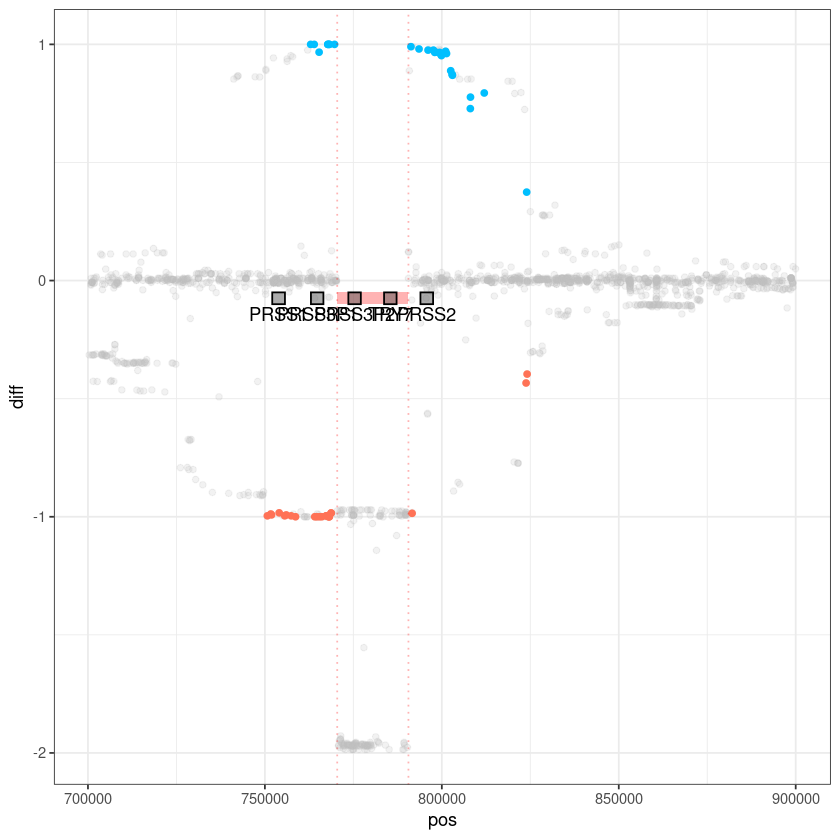

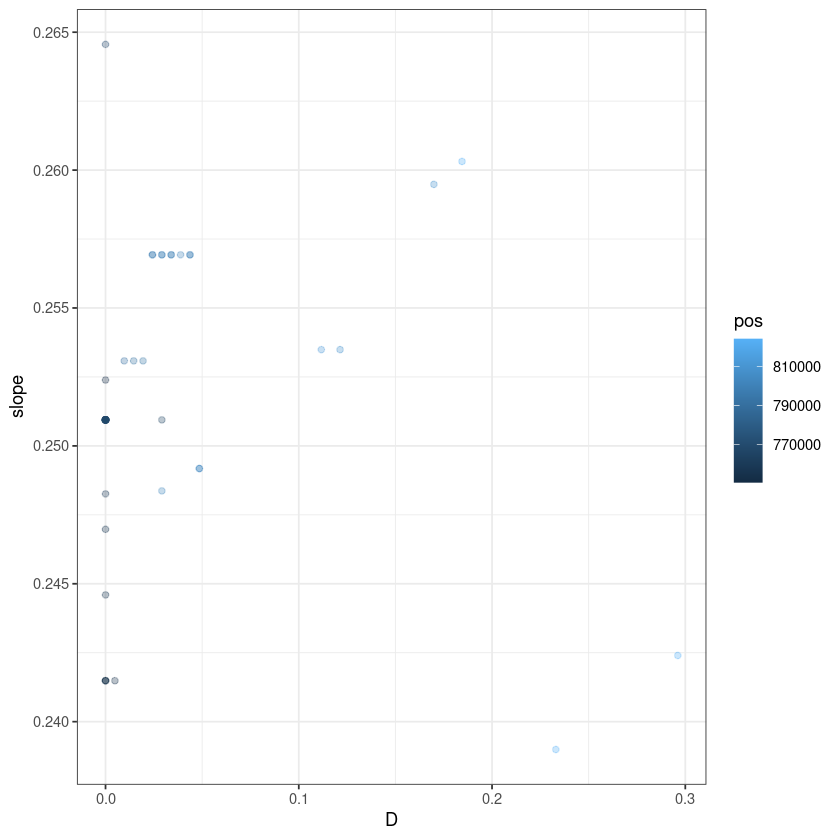

In [344]:
collapse.df <- as.data.frame(t(collapse_clusters(clusters$hap.df, imputed.hap.mat, to.plot=FALSE)))
collapse.df$pos <- as.numeric(rownames(collapse.df))

prss1 <- "ENSG00000204983.13"
prss2 <- "ENSG00000275896.5"
prss3p1 <- "ENSG00000250591.2"
prss3p2 <- "ENSG00000250606.4"

sub.gtex <- gtex.df %>% distinct()
sub.gtex <- sub.gtex[as.character(sub.gtex$phenotype_id) == prss2,]

vcf.snps <- data.frame(pos=getPOS(vcf), ref=getREF(vcf), alt=getALT(vcf))
merged.snps <- merge(sub.gtex, vcf.snps, by="pos", all.x=TRUE, suffix=c(".gtex", ".seq"))
reversed.snps <- merged.snps[!as.character(merged.snps$ref.gtex) == as.character(merged.snps$ref.seq),]$pos
reversed.snps <- na.omit(reversed.snps)

big.df <- merge(sub.gtex, collapse.df, all.x=TRUE)

big.df[big.df$pos %in% reversed.snps, ]$A <- 1- big.df[big.df$pos %in% reversed.snps, ]$A
big.df[big.df$pos %in% reversed.snps, ]$C <- 1- big.df[big.df$pos %in% reversed.snps, ]$C
big.df[big.df$pos %in% reversed.snps, ]$D <- 1- big.df[big.df$pos %in% reversed.snps, ]$D


plot.df <- data.frame(pos=collapse.df$pos, diff= collapse.df$D - collapse.df$A ) #(collapse.df$A + collapse.df$C)/2-collapse.df$D)
plot.df$slope <- 0
#plot.df[plot.df$pos %in% sub.gtex$pos,]$pos == sub.gtex[sub.gtex$pos %in% plot.df$pos,]$pos

plot.df[plot.df$pos %in% sub.gtex$pos,]$slope <- sub.gtex[sub.gtex$pos %in% plot.df$pos,]$slope
plot.df[plot.df$pos %in% reversed.snps,]$slope <- -1*plot.df[plot.df$pos %in% reversed.snps,]$slope

p <- ggplot(data=plot.df, aes(x=pos, y=diff)) +
        geom_point(color="grey", alpha=0.2) +
        geom_point(data=plot.df[plot.df$slope>0,], color="coral1") +
        geom_point(data=plot.df[plot.df$slope<0,], color="deepskyblue") + theme_bw()
add_gene_rectangles(p)         
                                                
colnames(big.df)
ggplot(data=big.df, aes(x=D, y=slope, colour=pos)) +
        geom_point(alpha=0.3) + theme_bw()

# BREAK DOWN D HAPLOTYPE

In [ ]:
start.pos <- min(na.omit(gwas.df[-log10(gwas.df$p) > 6, ]$pos))
end.pos <- max(na.omit(gwas.df[-log10(gwas.df$p) > 6, ]$pos))

mat.D <- imputed.hap.mat[as.numeric(rownames(imputed.hap.mat)) > start.pos &
                      as.numeric(rownames(imputed.hap.mat)) < end.pos,]

D <- clusters$hap.df[clusters$hap.df$cluster == "D",]$sample
mat.D <- mat.D[,colnames(mat.D) %in% D]
mat.D[mat.D < 0] <- NA

clusters.D <- hierarchical_cluster_haplotypes(mat.D, k=3, plot.clusters=TRUE,
                                dist.meth="manhattan", clust.meth="ward.D2")

rep <- c("BSP21108_03A.1", "OSK7142_03A.2", "OSK7704_03A.1", "OSK7173_03A.1", "CF010B1D2.1")
labels <- "mnopq"

clusters.D <- label_clusters(clusters.D, rep, labels)

mat.D[is.na(mat.D)] <- -1
collapse_clusters(clusters.D$hap.df, mat.D)


clusters.mod <- clusters
clusters.mod$df <- NA
clusters.mod$hap.df <- clusters.mod$hap.df[clusters.mod$hap.df$cluster != "D",]
clusters.mod$hap.df <- rbind(clusters.mod$hap.df, clusters.D$hap.df)

b.size <- ncol(hap.matrix)*3
b.n <- 11

platforms <- list(c("Omni5"), c("660W", "660K", "GWAS3"), c("GWAS1"), c("370K"))
predict.df <- do.call(rbind, lapply(platforms, FUN=predict_bootstrap, clust=clusters.mod,
                                    bootstrap.size=b.size, bootstrap.n=b.n))

In [ ]:
table(predict.df$cluster)

groups <- as.character(unique(clusters.D$hap.df$cluster))
groups

do.call("rbind", lapply(groups, FUN=function(x) cluster_regression(samples=predict.df$sample, x)))
                 
do.call("rbind", lapply(as.character(unique(array.df$cohort)),
    FUN=function(cohort) do.call("rbind", lapply(groups, cluster_regression, 
                samples=array.df[array.df$cohort == cohort,]$sample, note=cohort))))

                        
do.call("rbind", lapply(as.character(unique(array.df$platform)),
    FUN=function(platform) do.call("rbind", lapply(groups, cluster_regression, 
                samples=array.df[array.df$platform == platform,]$sample, note=platform))))

### PREDICT USING OBSERVED HAPLOTYPES

In [ ]:
predict_platform <- function(platform){                    
 
    samples <- array.df[array.df$platform %in% platform,]$sample
    pred.mat <- as.matrix(t(array.matrix[,colnames(array.matrix) %in% samples])) 

    #remove if missing >5% of data
    missing <- apply(pred.mat,2,FUN=function(x) sum(is.na(x)))
    pred.mat <- pred.mat[, missing/ncol(pred.mat) <= 0.05]
    samples <- rownames(pred.mat)
    pred.mat <- as.matrix(kNN(pred.mat, k=5, imp_var=FALSE))
    rownames(pred.mat) <- samples

    #train.mat <- permute.mat
    #class.lab <- hap.labels
    train.mat <- t(gt.count)
    class.lab <- sapply(rownames(train.mat), FUN=function(x) 
                        seq.clusters[as.character(seq.clusters$id)==as.character(x),]$haplotype)

    train.mat <- train.mat[,colnames(train.mat) %in% colnames(pred.mat)]
    pred.mat <- pred.mat[,colnames(pred.mat) %in% colnames(train.mat)]

    colnames(train.mat) <- sapply(colnames(train.mat), FUN=function(x) paste("V",x,sep=""))
    colnames(pred.mat) <- sapply(colnames(pred.mat), FUN=function(x) paste("V",x,sep=""))

    pnb <- poisson_naive_bayes(x=train.mat, y=class.lab, laplace=0.5)
    #summary(pnb)

    hap.prediction <- predict(pnb, pred.mat, type="class")
    hap.posterior <- predict(pnb, pred.mat, type = "prob")
    df <- data.frame(id=samples,haplotype=hap.prediction)
    df$posterior <- rowMaxs(hap.posterior)
    df$platform <- paste(platform, sep="", collapse="_")
    return(df)
}

platforms <- list(c("Omni5"), c("660W", "660K", "GWAS3"), c("GWAS1"), c("370K"))
predict.df <- do.call(rbind, lapply(platforms, predict_platform))

 make_confusion_matrix(
    sapply(matching.seq, function(x) as.character(seq.clusters[seq.clusters$id == x, ]$haplotype)),
    sapply(matching.array, function(x) as.character(predict.df[predict.df$id == x, ]$haplotype)))

ggplot(predict.df, aes(x=posterior, fill=platform, color=platform)) +
  geom_histogram(alpha=0.5, position="identity", bins=25) + theme_bw() +
  facet_wrap(~platform) + ggtitle("Posterior Probabilities")
                                 
ggplot(predict.df, aes(x=posterior, fill=haplotype, color=haplotype)) +
  geom_histogram(alpha=0.5, position="identity", bins=25) + theme_bw() +
  facet_wrap(~haplotype) + ggtitle("Posterior Probabilities")

In [ ]:
#adding deletion status as last column
#imputed.mat.out.del <- cbind(imputed.mat.out, del.status)

#fviz_nbclust(imputed.mat.out.del, kmeans, method ="silhouette")
#fviz_nbclust(imputed.mat.out.del, kmeans, method ="wss")


clust.out <- kmeans_cluster(imputed.mat.out.del, 4)
print("deletion status:")
clust.out$haplotypes[, "del.status"]
print("group size:")
print(clust.out$means$size)

out.hap.rep <- c("QUL28163_03A.1", "OSK7719_03A.1", "BSP21041_03A.2", "OSK7706_03A.1")
out.hap.order = ""
for (r in out.hap.rep){
    x <- clust.out$clusters[clust.out$clusters$sample == r,]$cluster
    out.hap.order <- paste(out.hap.order, x, sep="")
}

out.hap.names <- "ABCD"
clust.out$clusters$group <- chartr(out.hap.order, out.hap.names, clust.out$clusters$cluster)
clust.out$gt$group.1 <- chartr(out.hap.order, out.hap.names, clust.out$gt$cluster.1)
clust.out$gt$group.2 <- chartr(out.hap.order, out.hap.names, clust.out$gt$cluster.2)

write.table(clust.out$gt, "10x_clusters.txt", sep="\t", quote=FALSE, row.names = FALSE)

In [ ]:
categorize <- function(x=NA){
    
    if(is.na(x)){ return (c("coral1", "steelblue2",
                            "yellowgreen", "grey")) } 
    
    a=">=0.8" ; b="<0.8" ; c="<0.6" ; d="<0.4"
    
    y <- x
    y[x<0.8] <- b ; y[x<0.6] <- c ; y[x<0.4] <- d ; y[x>=0.8] <- a
    y <- factor(y, levels = c(a,b,c,d))
    return (y)   
}

plot_haplotypes <- function(merge.df, column, title){
    
    pos.df <- cluster.matrix[,colnames(cluster.matrix) %in% merge.df$pos]
    pos.df <- as.data.frame(t(pos.df))
    pos.df$pos <- as.numeric(rownames(pos.df))
    pos.df <- merge(pos.df, merge.df, by="pos", all.x=TRUE)

    pos.df$fill <- categorize(pos.df[,column])
    
    p <- ggplot(pos.df, aes(x=pos, y=-log10(p), fill=fill, color=beta>0)) +
      geom_point(shape=21, size=3, stroke=1) + theme_bw() + ggtitle(title) + 
      xlab("Position") + ylab("-log10 ( p-value )") + labs(colour = "Direction", fill="Average GT") +
      scale_fill_manual(values=categorize(), drop=FALSE) +
      scale_colour_manual(values=c("white", "black"),
                          labels = c("PROTECTIVE", "HARMFUL", ""),  drop=FALSE)

    p <- p + theme(panel.background = element_rect(fill = "grey80"))
    p <- add_gene_rectangles(p, label = FALSE)
    return(p)
}

reg.df <-regression.df[regression.df$var=="gt",]

options(warn=-1)

plot_haplotypes(reg.df,  "A", title="Haplotype A (no imputation)")
plot_haplotypes(gwas.df, "A", title="Haplotype A")

plot_haplotypes(reg.df,  "B", title="Haplotype B (no imputation)")
plot_haplotypes(gwas.df, "B", title="Haplotype B")

plot_haplotypes(reg.df,  "C", title="Haplotype C (no imputation)")
plot_haplotypes(gwas.df, "C", title="Haplotype C")

plot_haplotypes(reg.df,  "D", title="Haplotype D (no imputation)")
plot_haplotypes(gwas.df, "D", title="Haplotype D")

options(warn=0)

### VARIANTS IMPORTANT FOR HAPLOTYPE CLASSIFICATION

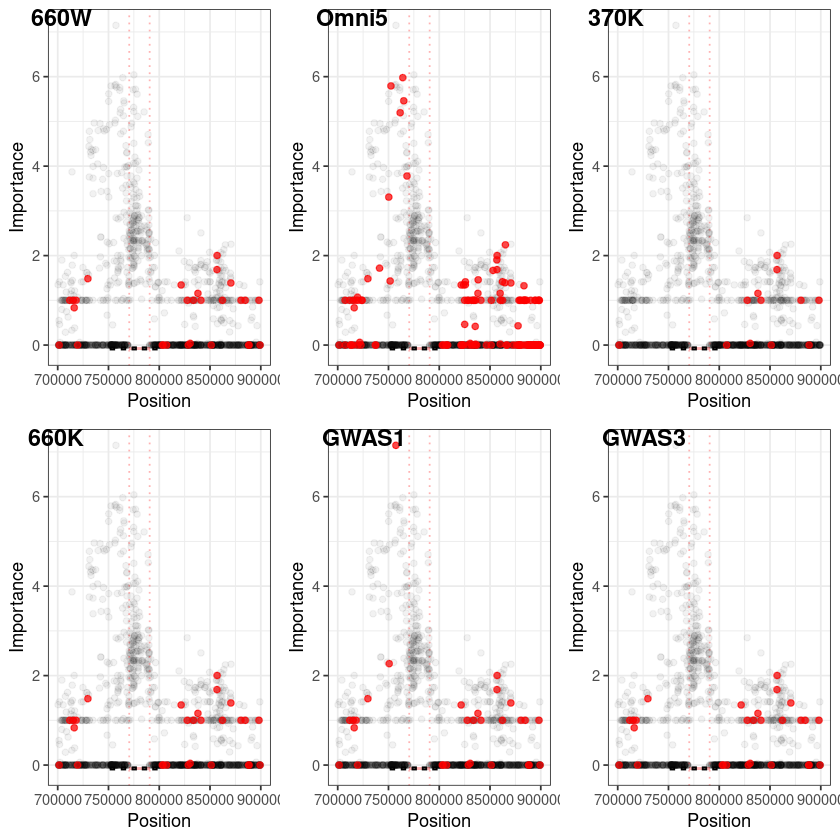

In [74]:
importance.df <- read.csv("variant_importance.txt", sep="\t")

get_platform_positions <- function(platform, missing.percent=0.1){
    
    ids <- array.df[array.df$platform %in% c(platform),]$sample
    g <- array.matrix[,colnames(array.matrix) %in% ids]
    x <- apply(g, 1, function(x) sum(is.na(x)))
    g <- g[x < missing.percent*ncol(g), ]
    return(rownames(g))
}

plot_array_density <- function(platform, df){   
    covered <- get_platform_positions(platform)
    p <- ggplot(df, aes(x=as.numeric(pos), y=abs(MeanDecreaseAccuracy))) +
      geom_point(alpha=0.05, colour="black") + theme_bw() +
      geom_point(data=df[df$pos %in% covered,], alpha=0.7, colour="red") +
      xlab("Position") + ylab("Importance") + labs(colour = "p<0.05")
    p <- add_gene_rectangles(p, label=FALSE)

    return(p)
}

platforms <- as.character(unique(array.df$platform))
plots <- lapply(platforms, FUN=plot_array_density, df=importance.df)

ggarrange(plotlist=plots, labels = platforms, legend="bottom", common.legend=TRUE)

### HAPLOTYPE ASSOCIATION TESTING

In [ ]:
char_count <- function(x, char){
    return(lengths(regmatches(x, gregexpr(char, x))))
}

associate_haplotype <- function(df, platform.filter=NA){

    if (!is.na(platform.filter)){ df <- df[df$platform %in% platform.filter,] }

    df$count.A <- as.numeric(sapply(df$haplotype, FUN=char_count, char="A"))
    df$count.B <- as.numeric(sapply(df$haplotype, FUN=char_count, char="B"))
    df$count.C <- as.numeric(sapply(df$haplotype, FUN=char_count, char="C"))
    df$count.D <- as.numeric(sapply(df$haplotype, FUN=char_count, char="D"))

    display <- function(model){ 
        print(round(summary(model)$coefficient, 5))
    }

    display(glm(MI ~ count.A, family="binomial", data=df))
    display(glm(MI ~ count.B, family="binomial", data=df))
    display(glm(MI ~ count.C, family="binomial", data=df))
    display(glm(MI ~ count.D, family="binomial", data=df))
}

In [ ]:
collapse_haps <- function(to.collapse.df, genotype.df, title="Collapsed Groups", to.plot=FALSE, free.cols=FALSE){
    hap_average <- function(hap, gt){
        samp <- to.collapse.df[to.collapse.df$haplotype == as.character(hap),]$sample
        rows <- genotype.df[, colnames(genotype.df) %in% samp]
        if (length(samp) < 1 ){
            return (NA)
        } else if (length(samp) == 1 ){
            return(rows)
        }

        return(rowMeans(rows, na.rm = TRUE))
    }
    haps <- unique(to.collapse.df$haplotype)
    collapsed.df <- do.call(rbind, na.omit(lapply(haps, FUN=hap_average)))
    rownames(collapsed.df) = haps

    collapsed.df <- collapsed.df[, colSums(is.na(collapsed.df)) < 3]

    if(to.plot){
        print(pheatmap(as.matrix(collapsed.df), color=RColorBrewer::brewer.pal(9, "Reds"),
         scale = "none", cluster_cols=free.cols, main=title))
    }
    return(collapsed.df)
    
}

### MAKE DIPLOID MATRIX

In [ ]:
make_clusters_diploid <- function(clusters){
    clusters <- as.data.frame(clusters)
    combos <- t(combn(rownames(clusters), m=2))

    for (cl in rownames(clusters)){
        m <- matrix(data = c(cl,cl), nrow = 1, ncol = 2)
        combos <- rbind(combos, m)
    }

    add_clusters <- function(i){ 
        a <- combos[i,1]
        b <- combos[i,2]

        newrow <- clusters[a,] + clusters[b,]
        rownames(newrow) <- paste(a,b,sep="")
        return(newrow)
    }

    diploid.clusters <- do.call(rbind, lapply(1:nrow(combos), FUN=add_clusters))
    return(diploid.clusters)
}

### CALCULATE DISTANCE

In [ ]:
calc_distance <- function(sample, clusters, dose=TRUE, make.plot=FALSE, plot.title="Diplotypes"){
    
    col <- array.matrix[, sample]
    ps <- rownames(array.matrix)
    filter <- !is.na(col) & ps %in% colnames(clusters) 
    #filter <- filter & ps > START_CLUSTER & ps <END_CLUSTER

    col <- col[filter]
    ps <- ps[filter]
    sub <- clusters[,colnames(clusters) %in% ps]
    
    if(!dose){ sub <- round(sub) }
    
    if(make.plot){
        pheatmap(as.matrix(sub), color=RColorBrewer::brewer.pal(9, "Reds"),
         scale = "none", cluster_cols=FALSE,
         main=plot.title)
    }
    
    distances <- apply(sub, 1, function(x) sqrt(sum(((x-col)^2))))
    return(distances)
}

### ASSIGN HAPLOTYPES TO GWAS DATA

In [ ]:
cluster.matrix <- read.csv("cluster_matrix.txt", header=TRUE, sep="\t", check.names=FALSE)
diploid.matrix <- make_clusters_diploid(cluster.matrix)

data.df <- assign_haplotype(diploid.matrix, genotype.df=array.matrix, phenotype.df=array.df, id.col="sample")
ptf = c("Omni5")

In [ ]:
seq.clusters <- read.csv("10x_clusters.txt", sep="\t")

matching.seq <- matching.seq[matching.seq %in% seq.clusters$id]
matching.array <- as.character(sapply(matching.seq, FUN=function(x) gms.df[gms.df$id_10x == x,]$gwas_sample))

seq.clusters$haplotype <- sapply(seq.clusters$id,
  function(x) paste(seq.clusters[seq.clusters$id == x,]$group.1, 
                    seq.clusters[seq.clusters$id == x,]$group.2, sep=""))
seq.clusters$haplotype <- sapply(seq.clusters$haplotype,
                                 FUN=function(s) paste(sort(unlist(strsplit(s, ""))), collapse = ""))

sub.seq.clusters <- seq.clusters[seq.clusters$id %in% matching.seq, ]

make_confusion_matrix <- function(predicted, expected){
    res <- data.frame(pred=predicted, exp=expected)
    levels=unique(c(unique(as.character(res$pred)), unique(as.character(res$exp))))
    res$pred <- factor(res$pred, levels)
    res$exp <- factor(res$exp, levels)

    confusionMatrix(res$pred, res$exp)
}

make_confusion_matrix(
    sapply(matching.seq, function(x) as.character(sub.seq.clusters[sub.seq.clusters$id == x, ]$haplotype)),
    sapply(matching.array, function(x) as.character(data.df[data.df$sample == x, ]$haplotype)))

In [ ]:
assign_haplotype <- function(clusters, genotype.df, phenotype.df, id.col, use.dosage=TRUE){
    
    distances <- lapply(colnames(genotype.df), FUN=calc_distance, 
                        clusters=clusters, dose=use.dosage)
    distance.matrix <- do.call(rbind, distances)
    rownames(distance.matrix) <- colnames(genotype.df)

    print(table(colnames(distance.matrix)[apply(distance.matrix, 1, which.min)]))
    df <- data.frame(sample=rownames(distance.matrix), 
                     haplotype=colnames(distance.matrix)[apply(distance.matrix, 1, which.min)])

    return( merge(df, phenotype.df, by=id.col, all.x=TRUE) )
}

In [ ]:
redo_clusters <- function(genotype.df, data.df, haps, to.plot=FALSE){
        
    n <- function(hap){
        return(sum(data.df$haplotype == hap))
    }

    dip.haps <- na.omit(unique(data.df$haplotype))
    clust <- list()
    for (hap in haps){ clust[hap] <- NA }
    
    collapsed.df <- collapse_haps(data.df, genotype.df, to.plot=to.plot)

    A_a <- collapsed.df["AA",]/2
    A <- A_a
    D_d <- collapsed.df["DD",]/2
    D <- D_d

    B_a <- collapsed.df["AB",] - A
    B_d <- collapsed.df["BD",] - D

    b.temp <- do.call(cbind, list(B_a*n("AB"), B_d*n("BD")))
    B <- rowSums(b.temp,na.rm=TRUE) / (n("AB") + n("BD"))

    sum.vec <- list(a=(collapsed.df["AC",] - A)*n("AC"))
    sum.n <- n("AC")
    if (n("DC") > 0){
        sum.vec$d <- (collapsed.df["DC",] - D)*n("DC")
        sum.n <- sum.n + n("DC")        
    }
    c.temp <- do.call(cbind, sum.vec)
    C <- rowSums(c.temp, na.rm=TRUE) /sum.n

    A_b <- collapsed.df["AB",] - A
    #A_c <- collapsed.df["AC",] - C
    A_d <- collapsed.df["AD",] - D
    a.temp <- do.call(cbind, list(A_a*n("AA"), A_b*n("AB"), A_d*n("AD")))
    A <- rowSums(a.temp, na.rm=TRUE) / (n("AA") + n("AB") + n("AD"))

    D_a <- collapsed.df["AD",] - A
    D_b <- collapsed.df["BD",] - B
    d.temp <- do.call(cbind, list(D_d*n("DD"), D_a*n("AD"), D_b*n("BD")))
    D <- rowSums(d.temp, na.rm=TRUE) / (n("DD") + n("AD") + n("BD"))

    updated.mat <- do.call(rbind, list(A, B, C, D))
    rownames(updated.mat) <- c("A", "B", "C", "D")

    diploid.matrix <- make_clusters_diploid(updated.mat)
    
    if(to.plot){
        pheatmap(updated.mat, color=RColorBrewer::brewer.pal(5, "Reds"),
         scale = "none", cluster_cols=FALSE,
         main="All matrix")
    }
    
    return(diploid.matrix)
}

In [ ]:
pheatmap(diploid.matrix, color=RColorBrewer::brewer.pal(5, "Reds"),
    scale = "none", cluster_cols=FALSE, main="All matrix")

ids <- data.df[data.df$platform %in% c("Omni5"),]$sample

sum(colnames(array.matrix) %in% ids)
df <- array.matrix[,colnames(array.matrix) %in% ids]

x <- apply(df, 1, function(x) sum(is.na(x)))

df <- df[x<100, ]
#y <- apply(df, 2, function(x) sum(is.na(x)))

pos <- rownames(df)[as.numeric(rownames(df)) < 770000]

sub <- diploid.matrix[,colnames(diploid.matrix) %in% pos]
df <- df[rownames(df) %in% colnames(sub),]
           
rownames(sub) <- sapply(rownames(sub), FUN=function(x) (paste("----------------------------", x)))
pheatmap(rbind(sub, t(df) ), color=RColorBrewer::brewer.pal(5, "Reds"),
    scale = "none", #cluster_cols=FALSE,
         main="All matrix")

                        
pheatmap(cluster.matrix[,colnames(diploid.matrix) %in% pos], color=RColorBrewer::brewer.pal(4, "Reds"),
    scale = "none", cluster_cols=FALSE, main="All matrix")

In [ ]:
snps <- c("750284",  "764089", "768212")

snps <- c("732350", "734809", "734813", "739775","741691","750168","750217","756794","770027")
array.matrix[rownames(array.matrix) %in% snps,]


pheatmap(cluster.matrix[,colnames(diploid.matrix) %in% snps], color=RColorBrewer::brewer.pal(4, "Reds"),
    scale = "none", cluster_cols=FALSE, main="All matrix")

sub <- diploid.matrix[,colnames(diploid.matrix) %in% snps]
pheatmap(sub, color=RColorBrewer::brewer.pal(4, "Reds"),
    scale = "none", cluster_cols=FALSE, main="All matrix")

rownames(sub) <- sapply(rownames(sub), FUN=function(x) (paste("---------------", x)))
pheatmap(rbind(sub, t(df[rownames(df) %in% snps,]) ), color=RColorBrewer::brewer.pal(5, "Reds"),
    scale = "none", cluster_cols=FALSE,cutree_rows=10,
         main="All matrix")



In [ ]:
cutoff = 1.05

informative.df <- importance.df[abs(importance.df$MeanDecreaseAccuracy)>cutoff &
              (importance.df$pos < GAP_START | importance.df$pos > GAP_END),]

mat <- diploid.matrix[,colnames(diploid.matrix) %in% informative.df$pos]

pheatmap(mat, color=RColorBrewer::brewer.pal(5, "Reds"),
    scale = "none", 
         #cluster_cols=FALSE, 
         main="Informative SNPs")


mat <- t(array.matrix[rownames(array.matrix) %in% as.character(informative.df$pos),])
mat[is.na(mat)] <- -1
pheatmap(mat, color=RColorBrewer::brewer.pal(5, "Reds"),
    scale = "none", 
         #cluster_cols=FALSE, 
         main="Informative SNPs")


In [ ]:
missing.count <- apply(mat, 2, FUN=function(x) sum(x < 0)) 
#hist(missing.count)
                       
mat2 <- mat[,missing.count < 7000]                   
pheatmap(mat2, color=RColorBrewer::brewer.pal(5, "Reds"),
    scale = "none", 
         #cluster_cols=FALSE, 
         main="Informative SNPs")

                       
rdf <- regression.df[regression.df$var == "gt" & complete.cases(regression.df),]
rdf <- rdf[rdf$pos %in% colnames(mat),]
rdf <- merge(rdf, importance.df, by="pos", all.x=TRUE)
                       
p <- ggplot(rdf, aes(x=as.numeric(pos), y=MeanDecreaseAccuracy)) +
  geom_point(alpha=0.15, colour="black") + theme_bw() +
  geom_point(data=rdf[rdf$pos %in% colnames(mat2),],alpha=0.7, colour="red") +
  xlab("Position") + ylab("-log10(p-value)") + labs(colour = "p<0.05")
p <- add_gene_rectangles(p, label=FALSE)
p

rdf[rdf$pos =="757318",]
                       
rdf[,c("pos","MeanDecreaseAccuracy")]

In [ ]:
# GWAS1
informative <- c("729701", "750699", "757318" )
# OMNI5
informative <- c("750284",  "764089", "768212")


In [ ]:

observed <- sapply(1:ncol(array.matrix), FUN=function(x) 
                        paste(array.matrix[rownames(array.matrix) == informative[1], x],
                              array.matrix[rownames(array.matrix) == informative[2], x],
                              array.matrix[rownames(array.matrix) == informative[3], x], sep="."))
       
class <- sapply(1:nrow(diploid.matrix), FUN=function(x) 
                        paste(round(diploid.matrix[x, colnames(diploid.matrix) == informative[1]]),
                              round(diploid.matrix[x, colnames(diploid.matrix) == informative[2]]),
                              round(diploid.matrix[x, colnames(diploid.matrix) == informative[3]]), sep="."))
label <- print(rownames(diploid.matrix))

                
prediction <- sapply(observed, function(x) ifelse(x %in% class, label[class == x], NA))

table(prediction)

prediction.df <- data.frame(sample=colnames(array.matrix), haplotype=prediction)
prediction.df <- merge(prediction.df, array.df, by="sample", all.x=TRUE)

associate_haplotype(df = prediction.df, platform.filter = c("Omni5"))

distance.df <- assign_haplotype(diploid.matrix, genotype.df=array.matrix, phenotype.df=array.df, id.col="sample")
                     
make_confusion_matrix( distance.df$haplotype, prediction.df$haplotype)

In [ ]:
dfs <- lapply(rownames(array.matrix), FUN=regress, 
              gt.df=array.matrix, p.df=array.df, dominant=FALSE)
regression.df <- do.call(rbind, dfs)

p <- ggplot(regression.df[regression.df$var == "gt",], 
            aes(x=pos, y=-log10(p), colour=beta >0)) +
  geom_point() + theme_bw() + 
xlab("Position") + ylab("-log10 p-value") + labs(colour = "Sample size")
  #geom_point(data=gwas, aes(x=pos, y=-log10(p)), colour="red", shape=11, size=2)
p <- add_gene_rectangles(p)
p

### READ-IN SEQUENCING DATA

In [ ]:
gt <- as.data.frame(extract.gt(vcf))

#sets unphased to missing
get_gt <- function(x,i=1){ 
    if (is.na(x)){ return(NA) }
    split <- strsplit(x, split=c("|","/"))
    if (split[[1]][2] == "/"){ return(NA) }
    return(split[[1]][i]) 
}

split_hap <- function(name, i=1){
    x <- lapply(gt[name], as.character)
    y <- sapply(unlist(x), get_gt, i)
    return(as.character(y))
}

h1 <- as.data.frame(mapply(colnames(gt), FUN=split_hap, i=1))
h2 <- as.data.frame(mapply(colnames(gt), FUN=split_hap, i=3))

add_hap <- function(name){
    options(warn=-1)
    x <- as.numeric(as.character(h1[,name]))
    x[is.na(x)] <- 0
    y <- as.numeric(as.character(h2[,name]))
    y[is.na(y)] <- 0
    options(warn=0)
    return( x+y )
}

gt.count <- mapply(colnames(h1), FUN=add_hap)
rownames(gt.count) <- getPOS(vcf)
gt.count[rownames(gt.count) %in% reversed.snps,] <- 2 - gt.count[rownames(gt.count) %in% reversed.snps,]

#remove positions with >1 variant
filter <- sapply(rownames(gt.count), function(x) sum(rownames(gt.count) == x) > 1)
gt.count <- gt.count[!filter,]

In [560]:
na.count = colSums(apply(combined.gt, 1, FUN=is.na))
overlap.gt <- combined.gt[na.count < 10,]
set.seed(428)

START_CLUSTER <- 748818
END_CLUSTER   <- 799779
overlap.gt <- overlap.gt[as.numeric(rownames(overlap.gt)) >748818 & as.numeric(rownames(overlap.gt)) < 799779,]
overlap.gt <- as.matrix(overlap.gt)

overlap.imputed.mat <- t(kNN(overlap.gt, k=4, imp_var=FALSE))
colnames(overlap.imputed.mat) <- rownames(overlap.gt)
#means <- kmeans(overlap.imputed.mat, centers = 7, nstart = 15)

dm <- diploid.matrix[colnames(diploid.matrix) %in% colnames(overlap.imputed.mat)]

df <- data.frame(cluster=means$cluster, mi=combined.mi)

#for (i in unique(means$cluster)){ 
#    print(paste(i, ":", round(mean(df[df$cluster == i,]$mi),3), ";", nrow(df[df$cluster == i,])))
#}

#print(fviz_cluster(means, geom = "point", data=overlap.imputed.mat) + theme_bw())

#fviz_nbclust(overlap.imputed.mat, kmeans, method ="silhouette")
#fviz_nbclust(overlap.imputed.mat, kmeans, method ="wss")

#pheatmap(rbind(means$centers, dm), color=RColorBrewer::brewer.pal(5, "Reds"),
#    scale = "none", cluster_cols=FALSE, main="All matrix")

cluster <- data.frame(sample=rownames(overlap.imputed.mat), group="NA", mi=combined.mi)
cluster$group <- as.character(cluster$group)
collect_hap <- function(hap, name){
    haps <- apply(overlap.imputed.mat, 1, FUN=function(x) all(x == hap))  
    cluster$group[cluster$sample %in% rownames(overlap.imputed.mat)[haps]] <<- name
    overlap.imputed.mat <<- overlap.imputed.mat[!haps,]
    print(paste(name, ":", sum(haps)))
}

collect_hap(c(0,2,0,2,2,2,0), "AA")             
collect_hap(c(1,1,1,1,1,1,1), "AD")             
collect_hap(c(2,0,2,0,0,0,2), "DD")             
collect_hap(c(0,1,0,1,1,1,1), "AB")             
collect_hap(c(1,0,1,0,0,0,2), "BD")
collect_hap(c(1,1,1,0,0,0,1), "DC")             
collect_hap(c(0,2,0,1,1,1,0), "AC")
collect_hap(c(0,1,0,0,0,0,1), "BC")

for (hap in unique(cluster$group)){
    df <- data.frame(sample=colnames(combined.gt), mi=combined.mi)
    ids <- na.omit(cluster[cluster$group == hap,]$sample)
    
    print(paste(hap, ":", round(mean(df[df$sample %in% ids,]$mi),3), ";", length(ids)))
}
                  
#pheatmap(rbind(rbind(means$centers, dm, overlap.imputed.mat)), color=RColorBrewer::brewer.pal(5, "Reds"),
#    scale = "none", cluster_cols=FALSE, main="All matrix")

                 
cluster[cluster$group %in% c("BD", "AB", "BC"),]

ERROR: Error in apply(combined.gt, 1, FUN = is.na): object 'combined.gt' not found


In [ ]:
data.df <- assign_haplotype(diploid.matrix, genotype.df=array.matrix, phenotype.df=array.df, id.col="sample")
associate_haplotype(df = data.df, platform.filter = c("Omni5"))
mean(data.df[data.df$haplotype %in% c("BD", "AB", "BC") & data.df$platform %in% c("Omni5"),]$MI)
mean(data.df[!data.df$haplotype %in% c("BD", "AB", "BC") & data.df$platform %in% c("Omni5"),]$MI)

data.df[data.df$haplotype %in% c("BD", "AB", "BC") & data.df$platform %in% c("Omni5"),]

In [615]:
library("Rsubread")
?featureCounts 
